## CL-Gym Example: Stable A-GEM on Rotated MNIST

In this example, we use Averaged Gradient Episodic Memory (A-GEM) to train on Rotated MNIST benchmark. We use the stable version of [AGEM](https://arxiv.org/abs/1812.00420.pdf) using [Stable SGD](https://proceedings.neurips.cc/paper/2020/file/518a38cc9a0173d0b2dc088166981cf8-Paper.pdf) parameters.

## 1. Defining Parameters
First, we need to define our parameters/config for our experiment.
We define all our parameters inside a python dictionary. The parameters define different aspects of continual learning examples. For example:
-  How many tasks should we learn?
-  What our batch-size will be?
-  What Optimizer will we use?
-  Where should we store our outputs?

In [1]:
import torch
import cl_gym as cl
# first let's create params/config for our experiment

def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # benchmark
            'num_tasks': 5,
            'epochs_per_task': 10,
            'per_task_memory_examples': 100,
            'batch_size_train': 256,
            'batch_size_memory': 32,
            'batch_size_validation': 256,

            # algorithm
            'optimizer': 'SGD',
            'learning_rate': 0.01,
            'momentum': 0.8,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            'device': torch.device('cuda:3' if torch.cuda.is_available() else 'cpu'), }

    trial_id = str(uuid.uuid4())
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

## 2. Training our continual learning algorithm

Before seeing the code, let's explain the components one more time:
### 2.1 Benchmark
* We use the `RotatedMNIST` benchmark for this example. The benchmark includes gradual rotations of MNIST digits for each task. Something like this.
<div>
<img src="https://user-images.githubusercontent.com/8312051/122752221-845a0300-d245-11eb-8892-7c4119ffe1a5.png" width="300"/>
</div>

In CL-Gym we use RotatedMNIST as follows:
```python
benchmark = cl.benchmarks.RotatedMNIST(num_tasks=5)
```
---------

### 2.2 Backbone

* We use a MLP model with two hidden layers like this:
<div>
<img src="https://user-images.githubusercontent.com/8312051/122753641-67beca80-d247-11eb-87d3-dec5cc2e63d6.png" width="300"/>
</div>

To import our backbone, we use:
```python
backbone = cl.backbones.MLP2Layers(input_dim=784, hidden_dim_1=100, hidden_dim_2=100, output_dim=10)
```

You can also create your own PyTorch models. The backbone in CL-Gym is simply a lightweight wrapper around PyTorch's ``nn.Module``.

--------

### 2.3 Collecting metrics with Callbacks

The `MetricCollector` callback evaluates the model at the end of each epoch, logs the metrics, plots the accuraies to file, and stores the validation accuracies as numpy arrays to file (see outputs folder).
```python
metric_callback = cl.callbacks.MetricCollecto(num_tasks=5,
                                              eval_interval='epoch',
                                              epochs_per_task=1)
```

-------

### 2.4  Using off-the-shelf continual learning algorithms

CL-Gym includes several continual learning algorithms. Here we use A-GEM algorithm with better parameters than the original paper:

```python
cl.algorithms.AGEM(backbone, benchmark, params)
```

You can also use other algorithms. For example, for Experience Replay method, you can use:
```python
cl.algorithms.ERRingBuffer(backbone, benchmark, params)
```


-------

### 2.5 Gluing everything together with the Trainer

The `Trainer` will orchestrate the experiment by handling the non-research part of continual learning experiments.

```
trainer = cl.trainer.ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])
```


The code below implements this note:

In [2]:
from datasets.FairMNIST import NoiseMNIST
from trainers.FairContinualTrainer import FairContinualTrainer
from algorithms.agem_sensitive import AGEM_Sensitive
from algorithms.finetune import Finetune

params = make_params()
# # benchmark: Rotated MNIST
# benchmark = cl.benchmarks.RotatedMNIST(num_tasks=params['num_tasks'],
#                                        per_task_memory_examples=params['per_task_memory_examples'],
#                                        per_task_rotation=22.5)
benchmark = cl.benchmarks.SplitCIFAR10(num_tasks=params['num_tasks'],
                                        per_task_memory_examples=params['per_task_memory_examples'])
params['benchmark'] = benchmark

# backbone: MLP with 2 hidden layers
# backbone = cl.backbones.MLP2Layers(input_dim=784, hidden_dim_1=32, hidden_dim_2=32, output_dim=10)
backbone = cl.backbones.ResNet18Small(multi_head=True, num_classes_per_head=5, num_classes=10, config = params)

# Algorithm: A-GEM
# algorithm = cl.algorithms.AGEM(backbone, benchmark, params)
# algorithm = AGEM_Sensitive(backbone, benchmark, params)
algorithm = Finetune(backbone, benchmark, params)

# algorithm = cl.algorithms.ERRingBuffer(backbone, benchmark, params)

# Callbacks
metric_manager_callback = cl.callbacks.MetricCollector(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])

# Make trainer
trainer = cl.trainer.ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])

trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())


Files already downloaded and verified
Files already downloaded and verified
---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 87.6, 'loss': 0.001196931228041649}
[2] Eval metrics for task 1 >> {'accuracy': 91.6, 'loss': 0.0008618070855736733}
[3] Eval metrics for task 1 >> {'accuracy': 92.3, 'loss': 0.0008207528665661812}
[4] Eval metrics for task 1 >> {'accuracy': 93.45, 'loss': 0.000662690207362175}
[5] Eval metrics for task 1 >> {'accuracy': 92.8, 'loss': 0.000761897012591362}
[6] Eval metrics for task 1 >> {'accuracy': 94.0, 'loss': 0.0007129562795162201}
[7] Eval metrics for task 1 >> {'accuracy': 93.95, 'loss': 0.0007104967832565307}
[8] Eval metrics for task 1 >> {'accuracy': 93.65, 'loss': 0.000730203352868557}
[9] Eval metrics for task 1 >> {'accuracy': 94.15, 'loss': 0.0007519370540976524}
[10] Eval metrics for task 1 >> {'accuracy': 93.3, 'loss': 0.0008438138812780381}
---------------------------- Task 2 -----------------

KeyboardInterrupt: 

In [4]:
backbone.input_shape

torch.Size([60000, 28, 28])

In [3]:
benchmark = cl.benchmarks.RotatedMNIST(num_tasks=params['num_tasks'],
                                       per_task_memory_examples=params['per_task_memory_examples'],
                                       per_task_rotation=22.5)
 

In [43]:
benchmark.trains[1]

In [ ]:
benchmark,

In [5]:
benchmark_cifar = cl.benchmarks.SplitCIFAR10(num_tasks=params['num_tasks'],
                                        per_task_memory_examples=params['per_task_memory_examples'])


Files already downloaded and verified
Files already downloaded and verified


In [6]:
benchmark_cifar.trains[1].inputs.shape[-3]

3

In [4]:
import torchvision
from cl_gym.benchmarks.transforms import get_default_mnist_transform, get_default_cifar_transform
DEFAULT_DATASET_DIR= "/home/jaeyoung/anaconda3/envs/cl-gym/lib/python3.8/site-packages/cl_gym/data"

mnist = torchvision.datasets.MNIST(DEFAULT_DATASET_DIR, train=True, download=True, transform=get_default_mnist_transform(5))
cifar10 = torchvision.datasets.CIFAR10(DEFAULT_DATASET_DIR, train=True, download=True, transform=get_default_cifar_transform(5, False))

Files already downloaded and verified


Text(0.5, 1.0, 'original')

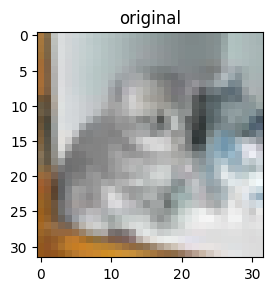

In [68]:
import torchvision

norm = benchmark.task_input_transforms[0].transforms[1]
mean = norm.mean
std = norm.std

denorm = torchvision.transforms.Compose([
        torchvision.transforms.Normalize(mean=tuple(-m / s for m, s in zip(mean, std)),
                std=tuple(1.0 / s for s in std)),
    ])

from torchvision.transforms.functional import to_pil_image
from matplotlib import pyplot as plt

task = 2
idx = 9

# img = original[idx]
img = denorm(benchmark.trains[task].inputs[idx])
# trans = sensitive_transform(mnist_train.data)[idx]

plt.figure()
plt.subplot(1,2,1)
# plt.imshow(to_pil_image(img), cmap='gray')
plt.imshow(to_pil_image(img))
plt.title('original')
# plt.subplot(1,2,2)
# plt.imshow(to_pil_image(trans), cmap='gray')
# plt.title('transform')


In [46]:
denorm(benchmark.trains[1].inputs[idx]).shape

torch.Size([3, 32, 32])